### Installing Qiskit

In [4]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer-gpu

In [5]:
!nvidia-smi

Tue May 28 09:10:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Libraries Importing


In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from math import log2
from sympy import *
import json, time, os

simulation_time = time.time() # to calculate simulation time
init_printing()

In [28]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())
# backend.set_options(device="GPU")

('CPU',)


In [29]:
# services = []

# for i in range(1,5):
#     services.append(QiskitRuntimeService(channel="ibm_quantum", token=os.getenv(f"TOKEN{i}")))

# backend = service.backend("ibm_osaka") # for real quantum
# backend = service.backend("ibm_kyoto") # for real quantum


### Problem definition

In [30]:
conf = json.load(open("conf_v3.json","r"))

In [31]:
C = conf["C"] # 2
S = conf["S"] # 2
P = conf["P"]
K = conf["K"]

L = int(log2(C)+1) # 2

random_seed = conf["random_seed"]
shots = conf["shots"] * 10
layers = conf["layers"]

iterations = 0

required_qubits = S * C + (S + 1) * L # l is log C

print("Requried Qubits: ", required_qubits)

Requried Qubits:  10


In [32]:
equations = []

### Formulation

#### Equations

In [33]:
for j in range(1, S + 1):
  equation = 0

  for i in range(1, C + 1):
    equation += symbols(f"x_{i}{j}") * P[i-1][j-1]

  for h in range(L):
    q1 = symbols(f"z_{h}")*2**h
    q2 = symbols(f"τ_{j}{h}")*2**h

    equation += (q2 - q1)

  equation = equation**2
  equation = equation.expand()
  equations.append(equation)

print(equations)

[x_21**2 - 2*x_21*z_0 - 4*x_21*z_1 + 2*x_21*τ_10 + 4*x_21*τ_11 + z_0**2 + 4*z_0*z_1 - 2*z_0*τ_10 - 4*z_0*τ_11 + 4*z_1**2 - 4*z_1*τ_10 - 8*z_1*τ_11 + τ_10**2 + 4*τ_10*τ_11 + 4*τ_11**2, x_12**2 + 2*x_12*x_22 - 2*x_12*z_0 - 4*x_12*z_1 + 2*x_12*τ_20 + 4*x_12*τ_21 + x_22**2 - 2*x_22*z_0 - 4*x_22*z_1 + 2*x_22*τ_20 + 4*x_22*τ_21 + z_0**2 + 4*z_0*z_1 - 2*z_0*τ_20 - 4*z_0*τ_21 + 4*z_1**2 - 4*z_1*τ_20 - 8*z_1*τ_21 + τ_20**2 + 4*τ_20*τ_21 + 4*τ_21**2]


#### Decodeing Equations

In [34]:
def args(equation):
    return Add.make_args(equation)


def prepare_equation(term):
    theta = 1
    terms = []
    if type(term) == Mul:
        for i in term.args:
            if i.is_Integer:
                theta = i
            else:
                terms.append(i)
    else:
        terms.append(term.args[0])
    return [theta, decode(terms)]


def decode(terms):
    output = []
    for term in terms:

        term = str(term)
        if term.startswith("z"):
            h = int(term[2])
            output.append(h)

        elif term.startswith("τ"):
            j = int(term[2])
            h = int(term[3])
            output.append(j * L + h)

        elif term.startswith("x"):
            i = int(term[2])
            j = int(term[3])
            temp = (S + 1) * (L)
            output.append(temp + (((i-1) * S) + (j-1)))

    return output

#### Other Registes

In [35]:
prepared_equations = []
for equation in equations:
  temp = []
  for term in args(equation):
    if len(term.args) != 0:
      temp.append(prepare_equation(term))
  prepared_equations.append(temp)
prepared_equations

### Implementation

#### Objective Function

In [38]:
def objective(bit_string):
  bit_string = bit_string[::-1] # since qiskit represent solution in least significant bit format
  cost = 0
  a = b = 0

  # equation a
  for h in range(L):
    cost += 2**h * int(bit_string[h])
  # I should check if it represent the actual data or not
  if cost > C :
    cost += (cost - C) *  K

  # equation b
  for j in range(1, S + 1):
    temp_cost = 0

    for i in range(1, C + 1):
      temp = (S + 1) * (L)
      temp_cost += int(bit_string[temp + (((i-1) * S) + (j-1))])

    for h in range(L):
      temp = (S + 1) * (L)
      q1 = int(bit_string[h]) * 2**h
      q2 = int(bit_string[temp + (((i-1) * S) + (j-1))]) * 2**h

      temp_cost += (q2 - q1)
    cost += temp_cost**2

  return [cost, a, b]

In [39]:
objective("00000000000001000")

#### Circuit

In [15]:
def layers_gen(p, initial_value = 1.0):
  return [initial_value] * p * 2

def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits):
      qc.h(i)

    # S0
    for i in range(L):
      theta = 2**i * -0.5
      qc.rz(theta,i)

    for layer_index in range(n_layers):
        for equation in prepared_equations:
          for term in equation:
            theta = int(term[0])
            locations = term[1]

            if len(locations) == 1: # i.e. trivial term
                qc.rz(theta * -1 * alpha[layer_index], locations[0])

            elif len(locations) == 2:
                qc.rz(theta * -0.5 * alpha[layer_index], locations[0]) # -1/4 * z1 = -1/4 * z1
                qc.rz(theta * -0.5 * alpha[layer_index], locations[1]) # -1/4 * z2 = -1/4 * z2
                qc.rzz(theta * 0.5 * alpha[layer_index], locations[0], locations[1]) # -1/4 * -z1z2 = 1/4 * z1z2

        # for qubit in range(required_qubits - 1):
        #     qc.rx(2 * gamma[layer_index] , qubit)

        # try with 2* and without

        # even
        temp = -1
        for i in range(1, required_qubits, 2):
            if(temp!= -1):
              qc.cx(temp,i)
              qc.rx(gamma[layer_index],temp)
              qc.ry(gamma[layer_index],temp)
              qc.cx(temp,i)
            temp = i

        # odd
        temp = -1
        for i in range(0, required_qubits, 2):
            if(temp!= -1):
              qc.cx(temp,i)
              qc.rx(gamma[layer_index],temp)
              qc.ry(gamma[layer_index],temp)
              qc.cx(temp,i)
            temp = i

        # first last
        qc.cx(0,required_qubits-1)
        qc.rx(0,required_qubits-1)
        qc.ry(0,required_qubits-1)
        qc.cx(0,required_qubits-1)

    qc.measure_all()
    return qc

In [16]:
total = [0] * 2
def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj, a, b = objective(bit_string)
        total[0] += a
        total[1] += b
        avg += obj * count
        sum_count += count
    return avg/sum_count

def get_expectation():

    def execute_circ(theta):
        global iterations
        qc = create_qaoa_circ(theta)
        tc = transpile(qc,backend,optimization_level=3,seed_transpiler=random_seed)

        counts = backend.run(tc, seed_simulator=random_seed, shots=shots).result().get_counts()
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [17]:
from scipy.optimize import minimize,differential_evolution
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA')
minimization_time = time.time() - start_time

res

250.0142578125
260.67177734375
253.67587890625
282.610546875
287.38115234375
254.92958984375
252.91669921875
277.4375
261.84619140625
282.62294921875
256.65068359375
253.2203125
258.9515625
254.40615234375
257.33271484375
263.5439453125
253.7751953125
246.97978515625
265.9607421875
252.03779296875
234.83056640625
267.8736328125
248.12255859375
265.0802734375
264.60712890625
249.5173828125
244.18388671875
261.96171875
242.51376953125
238.1697265625
238.16796875
255.453515625
242.30537109375
236.08427734375
241.99619140625
238.351953125
233.189453125
236.87216796875
235.5400390625
234.63876953125
237.579296875
237.51142578125
243.259375
239.98505859375
239.46982421875
233.912109375
232.76923828125
232.2154296875
233.97841796875
245.6828125
230.0458984375
235.63271484375
232.83427734375
237.6783203125
233.1943359375
232.06201171875
229.545703125
234.04013671875
238.4193359375
230.82470703125
234.44609375
240.27158203125
235.63857421875
230.5130859375
229.58564453125
227.528125
231.8569335

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 226.2583984375
       x: [ 8.842e-01  1.082e+00  9.946e-01  1.206e+00  1.066e+00
            9.797e-01  9.740e-01  8.880e-01  9.524e-01  9.845e-01]
    nfev: 118
   maxcv: 0.0

In [24]:
print("a:",total[0])
print("b:",total[1])

a: 0
b: 0


### Results

921
-----------------
BINGO
0000010100
19
-----------------
-----------------
BINGO
0000000100
17
-----------------
-----------------
BINGO
0000100000
14
-----------------
-----------------
BINGO
0000011000
8
-----------------
-----------------
BINGO
0000000000
8
-----------------
-----------------
BINGO
0000111000
6
-----------------
-----------------
BINGO
0000010000
5
-----------------
-----------------
BINGO
0000101000
5
-----------------
-----------------
BINGO
0000110100
5
-----------------
-----------------
BINGO
0000111100
4
-----------------
-----------------
BINGO
0000001000
4
-----------------
-----------------
BINGO
0000011100
2
-----------------
-----------------
BINGO
0000001100
1
-----------------
-----------------
BINGO
0000100100
1
-----------------
Solution 1101010100 cost: 41 count 79
Solution 1111001001 cost: 33 count 76
Solution 1010111101 cost: 18 count 65
Solution 1010100001 cost: 18 count 58
Solution 0000011111 cost: 1021 count 52
Solution 1011000011 cost: 1011 

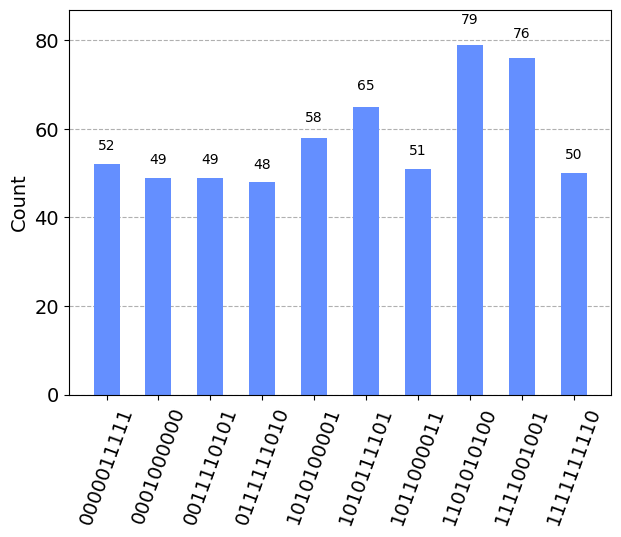

In [25]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
counts = backend.run(qc_res, seed_simulator=random_seed, shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
counts_cost = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
  if objective(key)[0] == 0:
    print("-----------------")
    print("BINGO")
    print(key)
    print(counts[key])
    print("-----------------")

for key in binary[:10]:
    print("Solution",key ,"cost:",objective(key)[0],"count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [26]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["C"] = C
counts["P"] = P
counts["S"] = S
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 0000010100 cost: 0 count 19


In [21]:
file = open(f"./{C}_{S}_{shots}_{layers}_{time.time_ns()}.json", "w")
file.write(json.dumps(counts))
file.flush()

In [22]:
counts["execution_time"]

In [23]:
minimization_time